In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from kan import *
from kan.utils import ex_round
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
torch.set_default_dtype(torch.float64)
from sympy import symbols, sympify
from preprocessing import *
from accessories import *
from plotting import plot_feature_importances, plot_overfitting
import shutil
from datetime import datetime
import time
from main import *

In [2]:
class NKAN():
    def __init__(self, dataset, seed, device, params):
        """Class that creates and trains a KAN model based on an input dataset.

        Args:
            dataset (dict): a dictionary containing four PyTorch tensors (train_input, train_output, test_input, test_output) and feature/output labels.
            seed (int): value to set random state for reproducible results
            device (str): cpu or gpu
            params (dict): a dictionary containing necessary parameters from hyperparameter tuning (depth, grid, k, steps, lamb, lamb_entropy, lr_1, and lr_2).
        """
        self.dataset = dataset
        self.seed = seed
        self.device = device
        self.depth = int(params["depth"])
        self.grid = int(params["grid"])
        self.k = int(params["k"])
        self.steps = int(params["steps"])
        self.lamb = params["lamb"]
        self.lamb_entropy = params["lamb_entropy"]
        self.lr_1 = params["lr_1"]
        self.lr_2 = params["lr_2"]
        self.hidden_nodes_per_layer = self.dataset["train_input"].shape[1]
        # depth is the number of layers, we have to create a list for pykan to
        # generate the kan with these two dimensions
        self.hidden_nodes = [self.hidden_nodes_per_layer for i in range(self.depth)]
        self.width = [self.dataset['train_input'].shape[1]] + self.hidden_nodes + [self.dataset['train_output'].shape[1]]
        self.data = {
            'train_input':self.dataset['train_input'],
            'train_label':self.dataset['train_output'],
            'test_input':self.dataset['test_input'],
            'test_label':self.dataset['test_output']
        }


    def get_model(self, save=False, save_as=None):
        """Uses input dataset to train and return a KAN model.

        Args:
            save (bool, optional): determines whether or not to save the model object to be reloaded later. Defaults to False.
            save_as (str, optional): name of the saved model object in /models. Defaults to None.

        Returns:
            pykan KAN model object: model trained on dataset provided to class
        """
        print(f'WIDTH:{self.width}')
        model = KAN(width=self.width, grid=self.grid, k=self.k, seed=self.seed, device=self.device)
        data = {
            'train_input':self.dataset['train_input'],
            'train_label':self.dataset['train_output'],
            'test_input':self.dataset['test_input'],
            'test_label':self.dataset['test_output']
        }
        model.fit(data, opt='LBFGS', steps=self.steps, lamb=self.lamb, lamb_entropy=self.lamb_entropy, lr=self.lr_1, reg_metric='edge_backward')
        print("Model trained.")
        return model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_name = 'CHF_TEST26'
dataset  = get_chf(cuda=True)
chf_best = {'depth': 3, 'grid': 8, 'k': 8, 'lamb': 3.3619635794339965e-07, 'lamb_entropy': 2.078997799175118, 'lr_1': 1.25, 'lr_2': 1.25, 'steps': 20}
chf_kan = NKAN(dataset=dataset, seed=42, device=device, params=chf_best)

WIDTH:[6, 6, 6, 6, 1]
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 6.31e-03 | test_loss: 5.68e-03 | reg: 4.81e+01 | : 100%|█| 20/20 [00:19<00:00,  1.01it


saving model version 0.1
Model trained.


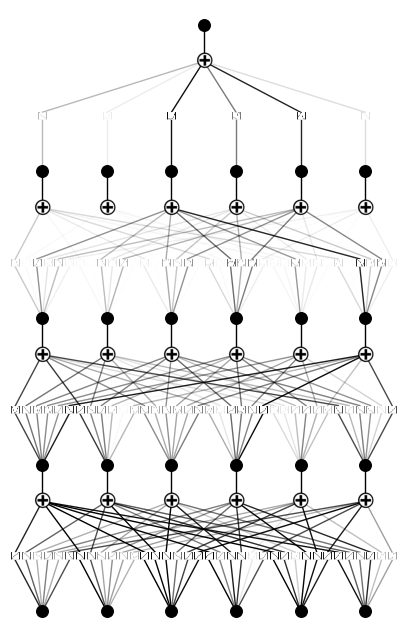

In [4]:
model = chf_kan.get_model()
model.plot()

In [5]:
grids = [10,20,30,50]
#grids = [5]

train_rmse = []
test_rmse = []
cont_train_rmse = []
cont_test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(chf_kan.data, opt='LBFGS', steps=chf_kan.steps, 
                        lamb=chf_kan.lamb, lamb_entropy=chf_kan.lamb_entropy, lr=chf_kan.lr_2, stop_grid_update_step=20)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())
    cont_train_rmse += results['train_loss']
    cont_test_rmse += results['test_loss']

saving model version 0.2


| train_loss: 3.87e-03 | test_loss: 3.39e-03 | reg: 2.37e+01 | : 100%|█| 20/20 [00:19<00:00,  1.02it


saving model version 0.3
saving model version 0.4


| train_loss: 2.55e-03 | test_loss: 2.81e-03 | reg: 2.31e+01 | : 100%|█| 20/20 [00:24<00:00,  1.24s/


saving model version 0.5
saving model version 0.6


| train_loss: 2.02e-03 | test_loss: 2.54e-03 | reg: 2.28e+01 | : 100%|█| 20/20 [00:31<00:00,  1.58s/


saving model version 0.7
saving model version 0.8


| train_loss: 7.09e-03 | test_loss: 2.54e-03 | reg: 2.28e+01 | : 100%|█| 20/20 [00:09<00:00,  2.03it


saving model version 0.9


In [6]:
width = [6, 6, 6, 6,1]
layer_params = [width[i]*width[i+1] for i in range(len(width) - 1)]
n_params = np.array(grids) * np.sum(layer_params)

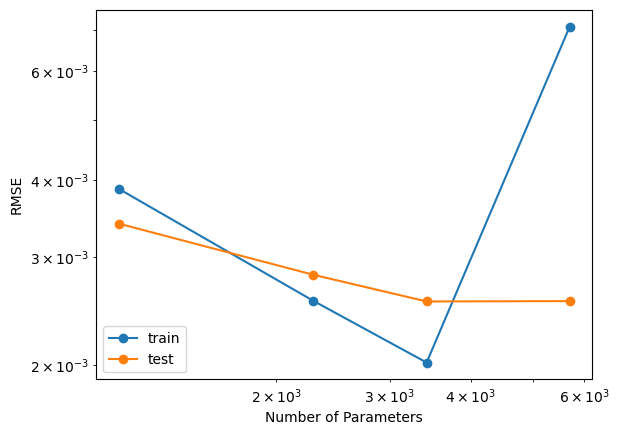

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(n_params, train_rmse, marker="o")
ax1.plot(n_params, test_rmse, marker="o")
ax1.legend(['train', 'test'], loc="lower left")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Parameters')
ax1.set_ylabel('RMSE')
fig.show()

saving model version 0.10


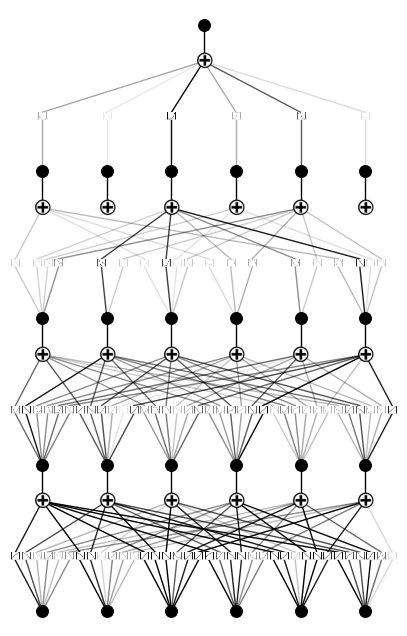

In [54]:
model = model.prune()
model.plot()

In [55]:
model.auto_symbolic(weight_simple=0)

fixing (0,0,0) with tan, r2=0.9941923958225366, c=3
fixing (0,0,1) with tan, r2=0.9771451723368878, c=3
fixing (0,0,2) with tan, r2=0.9147173560125399, c=3
fixing (0,0,3) with arctan, r2=0.9799269561434429, c=4
fixing (0,0,4) with x^3, r2=0.9677393190587361, c=3
fixing (0,0,5) with arctan, r2=0.9927070448963183, c=4
fixing (0,1,0) with tan, r2=0.9826161560573796, c=3
fixing (0,1,1) with arctan, r2=0.9938492024984952, c=4
fixing (0,1,2) with sgn, r2=0.4036707603828492, c=3
fixing (0,1,3) with tan, r2=0.993882625126537, c=3
fixing (0,1,4) with arctan, r2=0.8900486850214069, c=4
fixing (0,1,5) with gaussian, r2=0.692881578939287, c=3
fixing (0,2,0) with gaussian, r2=0.999464808219172, c=3
fixing (0,2,1) with tanh, r2=0.998146788716053, c=3
fixing (0,2,2) with arccos, r2=0.9994263212654577, c=4
fixing (0,2,3) with x^3, r2=0.9771024036382457, c=3
fixing (0,2,4) with x^1.5, r2=0.9970526827057072, c=4
fixing (0,2,5) with abs, r2=0.9957732688563081, c=3
fixing (0,3,0) with arctanh, r2=0.998765

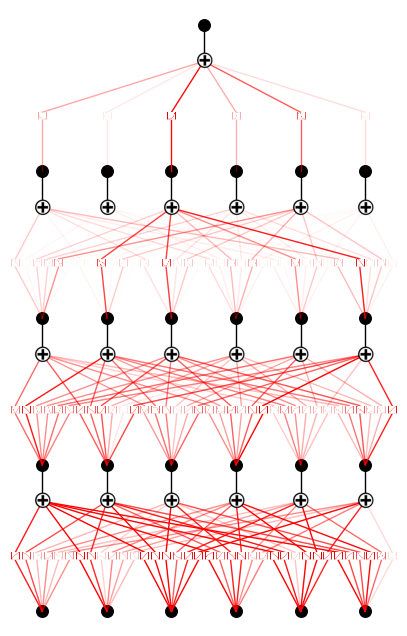

In [56]:
model.plot()

In [57]:
formula = model.symbolic_formula()[0][0]
print(formula)

-7.57294586720457*(-0.092222713636548*(-0.332939094487598*cos(0.28185952651392*(-x_4 - 0.292597376788553)**4 + 0.354988225241946*(-x_5 - 0.429232523492055)**2 + 0.029576702911369*tanh(8.95592*x_6 - 6.75832) + 0.151515151294586*Abs(8.9824*x_3 - 1.2244) - 0.24940172597793*atan(1.71352*x_1 - 1.17544) + 1.23712391635396 + 0.199675992353231*exp(-11.75392656*(0.180889044452222 - x_2)**2)) - 0.736888768796458*tanh(3.64710615877885*(0.473230242388571 - x_1)**3 + 0.882574710342563*(x_3 + 0.362303463717021)**(3/2) + 0.220851822647365*sin(9.35736*x_6 + 3.42536) - 1.55291537849086*tan(1.324*x_5 + 2.65896) - 0.540166651598091*atan(6.51256*x_2 - 4.66248) + 0.271648281371945 + 0.280837887813832*exp(-38.44*(0.0683870967741935 - x_4)**2)) + 0.225294231699275*atan(0.0980702105301884*cos(3.80408*x_5 + 4.98968) + 0.105904382147721*tan(2.59384*x_1 + 5.00928) + 0.726296246802518*tan(1.83824*x_4 + 8.57904) - 4.79157425750878*acos(0.431999999999999*x_3 + 0.198239999999999) + 0.732448938058112*atan(2.72504*x_6

In [58]:
from sys import getsizeof

In [59]:
getsizeof(formula)

64